# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.123191,0.077597,0.451932,0.122542,0.050493,6.10557,0.165442,5.569210,1.990229,4.936696,40.823586,19339994.0,4.936696,5.569210,1.990229,0.165442
1,1,0,20.0,0.123191,0.077597,0.451932,0.122542,0.050493,6.10557,0.296394,0.924449,0.689131,0.845708,52.540352,19339994.0,0.845708,0.924449,0.689131,0.296394
2,2,0,30.0,0.123191,0.077597,0.451932,0.122542,0.050493,6.10557,0.333930,0.154409,0.163861,0.141398,54.807976,19339994.0,0.141398,0.154409,0.163861,0.333930
3,3,0,40.0,0.123191,0.077597,0.451932,0.122542,0.050493,6.10557,0.342329,0.025796,0.033973,0.023623,55.227009,19339994.0,0.023623,0.025796,0.033973,0.342329
4,4,0,50.0,0.123191,0.077597,0.451932,0.122542,0.050493,6.10557,0.344020,0.004310,0.006569,0.003947,55.302410,19339994.0,0.003947,0.004310,0.006569,0.344020


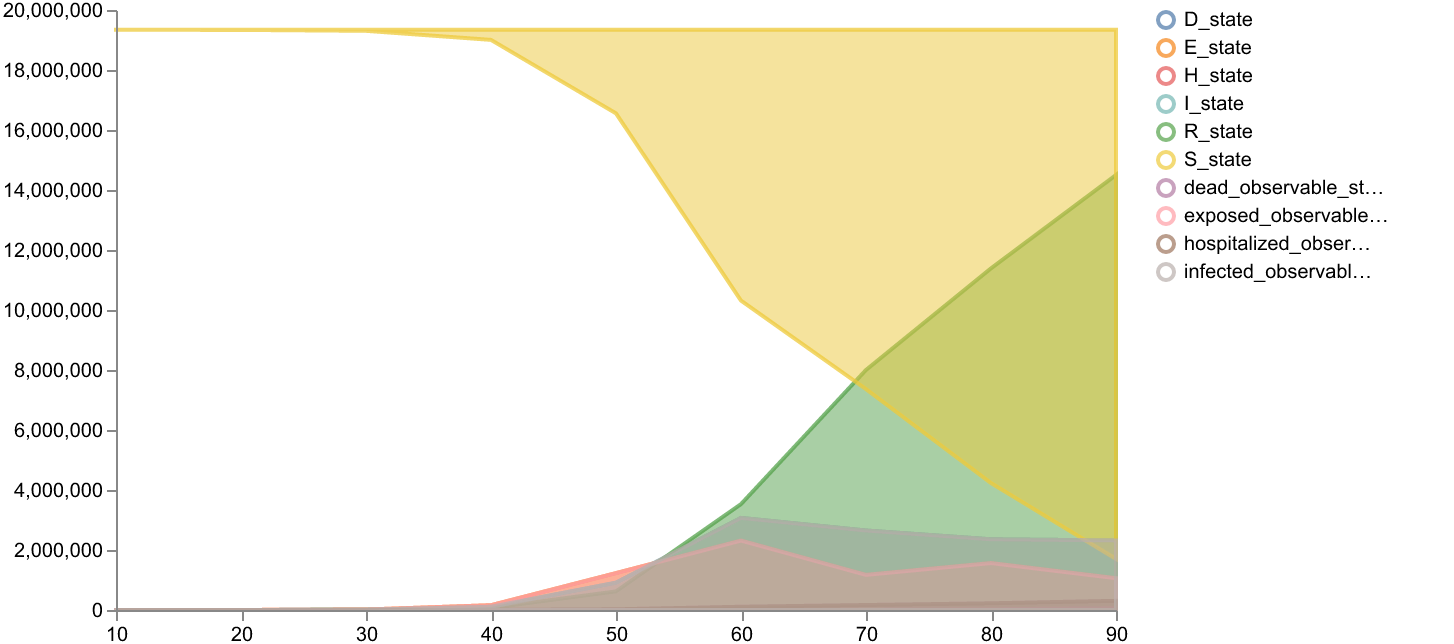

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample from model 2

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_beta_nc_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.705072,0.629364,0.084246,0.256897,0.010484,0.081643,13.429727,0.023717,8.543540,0.201108,13.371726,46.667248,19339986.0,13.371726,8.543540,0.201108,0.023717
1,1,0,20.0,0.705072,0.629364,0.084246,0.256897,0.010484,0.081643,13.429727,0.049582,2.800271,0.109292,4.692041,68.193703,19339986.0,4.692041,2.800271,0.109292,0.049582
2,2,0,30.0,0.705072,0.629364,0.084246,0.256897,0.010484,0.081643,13.429727,0.061316,0.946553,0.042844,1.591948,75.619446,19339986.0,1.591948,0.946553,0.042844,0.061316
3,3,0,40.0,0.705072,0.629364,0.084246,0.256897,0.010484,0.081643,13.429727,0.065703,0.320507,0.015303,0.539151,78.140663,19339986.0,0.539151,0.320507,0.015303,0.065703
4,4,0,50.0,0.705072,0.629364,0.084246,0.256897,0.010484,0.081643,13.429727,0.067245,0.108535,0.005290,0.182578,78.995087,19339986.0,0.182578,0.108535,0.005290,0.067245


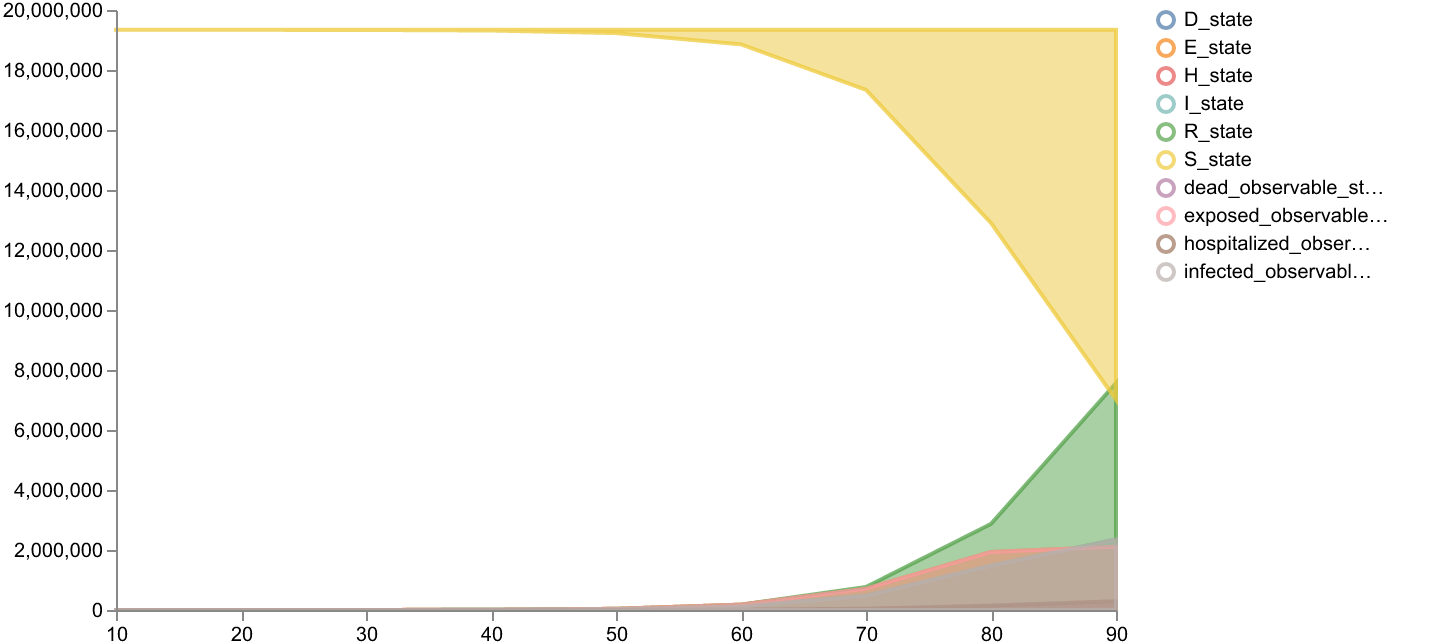

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,10.0,0.057808,0.942191,0.677465,0.645265,0.188475,0.193519,0.016729,...,0.012369,89.557701,0.773466,62.119305,64.931313,19339854.0,62.119305,89.557701,0.773466,0.012369
1,1,0,20.0,0.057808,0.942191,0.677465,0.645265,0.188475,0.193519,0.016729,...,0.097919,390.695068,4.597474,270.805664,362.559235,19338984.0,270.805664,390.695068,4.597474,0.097919
2,2,0,30.0,0.057808,0.942191,0.677465,0.645265,0.188475,0.193519,0.016729,...,0.576924,1742.686401,27.041212,1205.422119,1660.988892,19335408.0,1205.422119,1742.686401,27.041212,0.576924
3,3,0,40.0,0.057808,0.942191,0.677465,0.645265,0.188475,0.193519,0.016729,...,3.325353,7983.541992,161.728439,5511.067871,7446.383789,19318958.0,5511.067871,7983.541992,161.728439,3.325353
4,4,0,50.0,0.057808,0.942191,0.677465,0.645265,0.188475,0.193519,0.016729,...,19.386734,37379.125000,969.046997,25851.685547,33855.500000,19241968.0,25851.685547,37379.125000,969.046997,19.386734


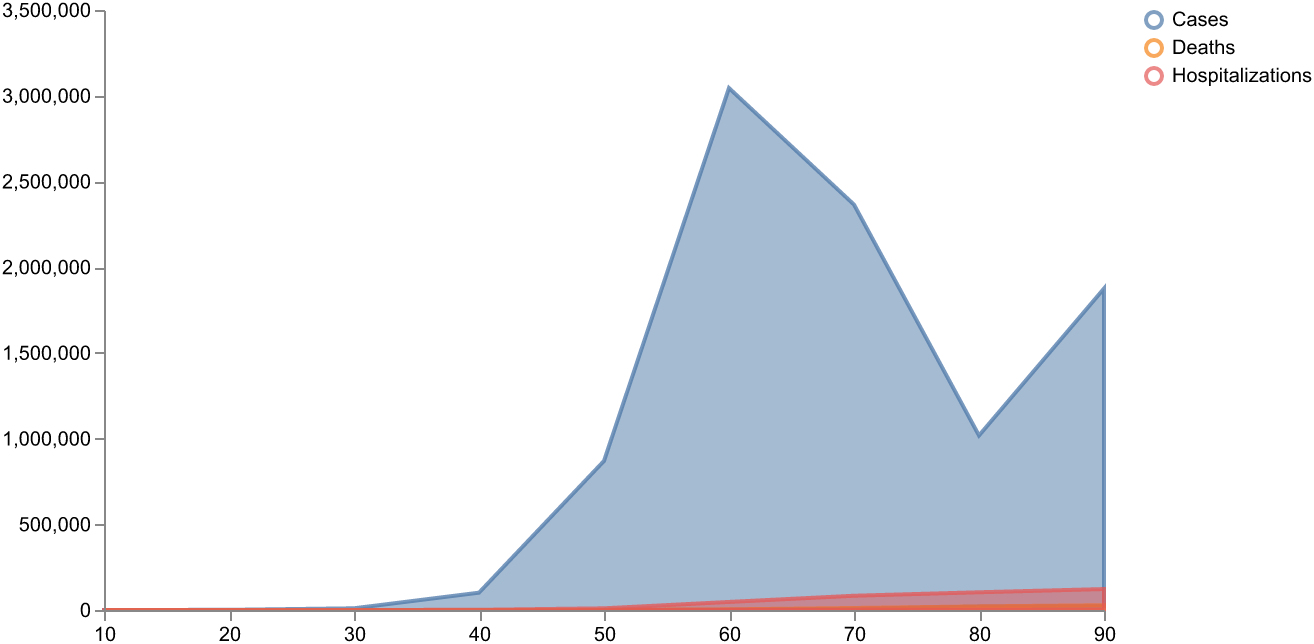

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibales or observables to columns in the dataset. The `data_mapping` must be a dictionary where the keys are column names in the dataset, and the values are the state variables or observables they are mapped to (as in, `data_mapping = {"column_name": "observable/state_variable"}`).

In [7]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 40.16524514555931}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.3888, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.5272, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.4188, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1596, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0749, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(8.1717, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.145936,0.393994,0.406049,0.148522,0.035008,9.088596,0.197039,29.003132,4.607273,18.039297,64.113312,19339934.0,18.039297,29.003132,4.607273,0.197039
1,1,0,20.0,0.145936,0.393994,0.406049,0.148522,0.035008,9.088596,0.549066,27.678047,5.189885,17.237494,134.806976,19339844.0,17.237494,27.678047,5.189885,0.549066
2,2,0,30.0,0.145936,0.393994,0.406049,0.148522,0.035008,9.088596,0.909153,26.426350,5.062489,16.458004,202.972214,19339790.0,16.458004,26.426350,5.062489,0.909153
3,3,0,40.0,0.145936,0.393994,0.406049,0.148522,0.035008,9.088596,1.256203,25.231146,4.848063,15.713667,268.144287,19339728.0,15.713667,25.231146,4.848063,1.256203
4,4,0,50.0,0.145936,0.393994,0.406049,0.148522,0.035008,9.088596,1.587996,24.089891,4.630753,15.002922,330.380493,19339670.0,15.002922,24.089891,4.630753,1.587996


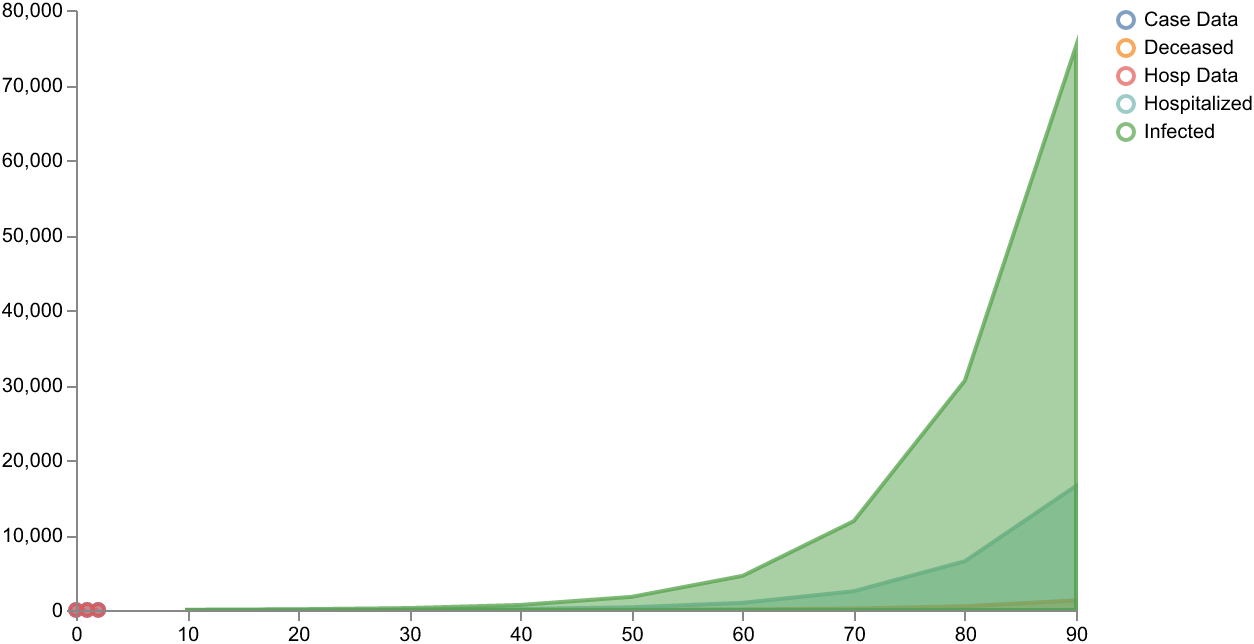

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:184: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby("sample_id").apply(rework).reset_index(drop=True)


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.5,15.959143,1.233078,0.069708,999.698242
1,1,0,2.0,0.5,15.959143,1.907941,0.166586,998.926514
2,2,0,3.0,0.5,15.959143,2.950737,0.316449,997.733398
3,3,0,4.0,0.5,15.959143,4.560056,0.548133,995.893066
4,4,0,5.0,0.5,15.959143,7.038998,0.905972,993.055969


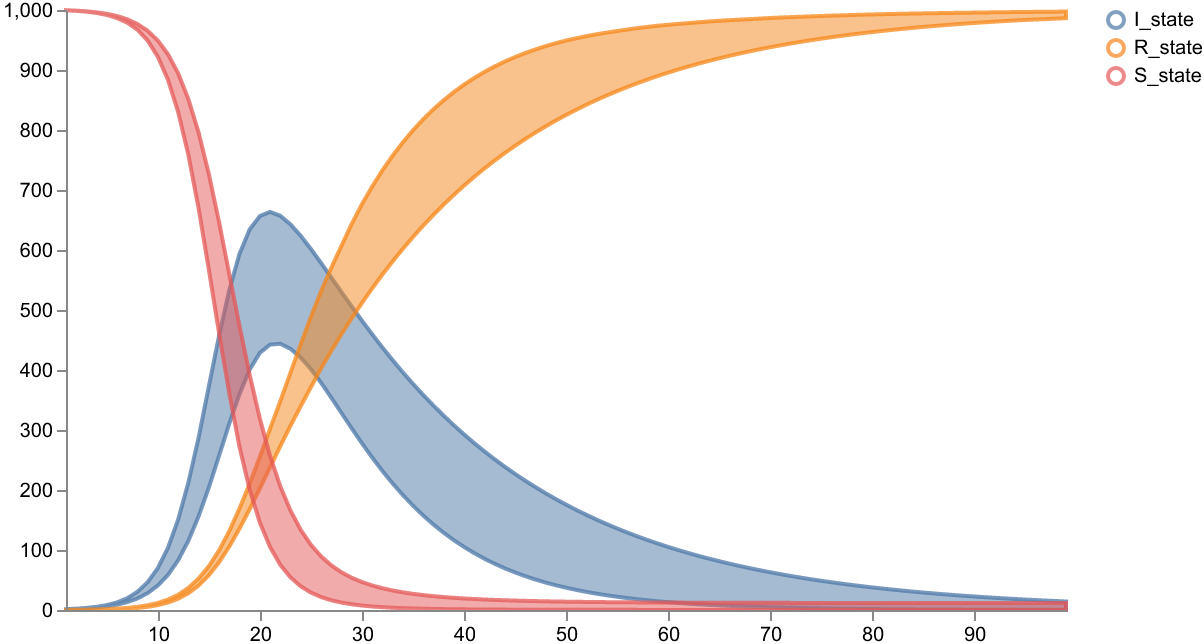

In [10]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.264085,10.412655,1.182638,0.104563,999.712219
1,1,0,2.0,0.264085,10.412655,1.398517,0.228217,999.373291
2,2,0,3.0,0.264085,10.412655,1.653642,0.374437,998.972046
3,3,0,4.0,0.264085,10.412655,1.955083,0.547320,998.497620
4,4,0,5.0,0.264085,10.412655,2.311158,0.751705,997.937195


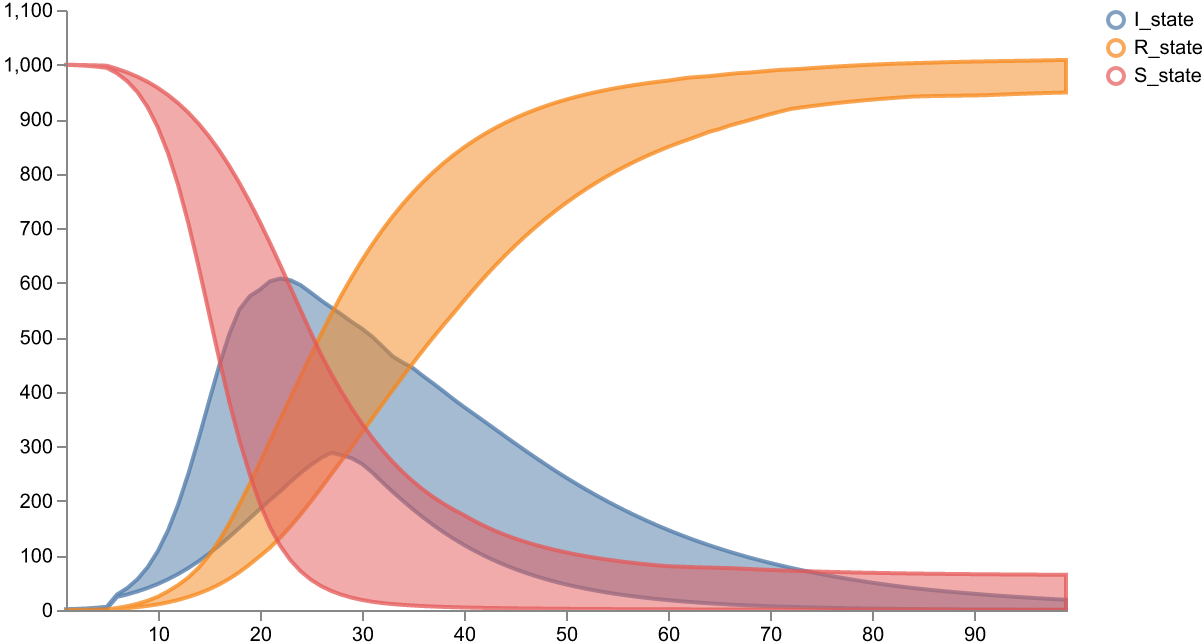

In [11]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 200.

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(200.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [ ]:
import numpy as np
from typing import Dict, List
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]

In [ ]:
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

### Sample using the optimal policy as an intervention

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface for optimizing start time

In [ ]:
initial_guess_interventions = 0.0
bounds_interventions = [[start_time], [end_time]]

risk_bound = 300.0
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.15]),
)
opt_result = pyciemss.optimize(
    model3,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=0.0,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=2,
    solver_method="euler",
)

print(f'Optimal policy:', opt_result["policy"])
print(opt_result)

### Sample with the intervention implemented at the optimal time

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(
    model3,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result["policy"]),
    solver_method="euler",
)

display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)